# Confronto Classificatori - GUIDE Dataset

**Obiettivo:** Confronto di diversi classificatori sul dataset GUIDE (target binario)

**Classificatori:**
1. K-Nearest Neighbors (k=3)
2. SVM (Linear)
3. SVM (RBF)
4. Gaussian Process
5. Decision Tree
6. Random Forest
7. Neural Network (MLP)
8. AdaBoost
9. Gaussian Naive Bayes
10. Quadratic Discriminant Analysis

**Caratteristiche:**
- Dataset: processed_v3 (stesso di XGBoost)
- Timeout: 4 minuti per training
- Metriche: Accuracy, Precision, Recall, F1, ROC AUC
- Correlation matrix finale tra predizioni

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Importa tutti i classificatori necessari
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Metriche di valutazione
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report
)

# Threading per timeout
from threading import Thread
import queue
import functools

print("Librerie caricate con successo!")

# Configurazione plot
plt.style.use('seaborn-v0_8-darkgrid')  # stile compatibile
%matplotlib inline
sns.set_theme(style="darkgrid")

Librerie caricate con successo!


## 1. Caricamento Dati

In [14]:
# Carica gli stessi dati usati per XGBoost
print("Caricamento dataset processed_v3...")

X_train = pd.read_csv('../data/processed_v3/X_train.csv')
X_test = pd.read_csv('../data/processed_v3/X_test.csv')
y_train = pd.read_csv('../data/processed_v3/y_train.csv')['BinaryIncidentGrade']
y_test = pd.read_csv('../data/processed_v3/y_test.csv')['BinaryIncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribuzione y_train:")
print(y_train.value_counts(normalize=True))

Caricamento dataset processed_v3...
X_train: (314230, 53)
X_test: (134671, 53)

Distribuzione y_train:
BinaryIncidentGrade
0    0.78701
1    0.21299
Name: proportion, dtype: float64
X_train: (314230, 53)
X_test: (134671, 53)

Distribuzione y_train:
BinaryIncidentGrade
0    0.78701
1    0.21299
Name: proportion, dtype: float64


## 2. Timeout Decorator

Implementiamo un decorator per interrompere il training dopo 4 minuti

In [15]:
from threading import Thread
import queue

def timeout(seconds):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            result_queue = queue.Queue()
            
            def worker():
                try:
                    result = func(*args, **kwargs)
                    result_queue.put(('success', result))
                except Exception as e:
                    result_queue.put(('error', e))
            
            thread = Thread(target=worker)
            thread.daemon = True
            thread.start()
            
            try:
                status, result = result_queue.get(timeout=seconds)
                if status == 'error':
                    raise result
                return result
            except queue.Empty:
                raise TimeoutError(f"Training interrotto dopo {seconds} secondi")
            
        return wrapper
    return decorator

@timeout(240)  # 4 minuti
def fit_with_timeout(clf, X, y):
    return clf.fit(X, y)

def evaluate_classifier(name, clf, X_train, X_test, y_train, y_test):
    """Valuta un classificatore con timeout e ritorna metriche e predizioni"""
    print(f"\n{'='*70}")
    print(f"Training {name}...")
    print(f"{'='*70}")
    
    start_time = time()
    
    try:
        # Sampling per modelli lenti
        if name in need_sampling:
            print("Usando subset del dataset per training veloce...")
            X_train_sub, y_train_sub = get_subsample(X_train, y_train)
            print(f"Dimensione subset: {len(X_train_sub):,} samples")
        else:
            X_train_sub, y_train_sub = X_train, y_train
        
        # Training con timeout
        clf = fit_with_timeout(clf, X_train_sub, y_train_sub)
        
        # Predizioni
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            y_pred_proba = clf.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = y_pred
        
        # Metriche
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        training_time = time() - start_time
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, digits=4))
        print(f"\nROC AUC: {roc_auc:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
        
        return {
            'name': name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'training_time': training_time,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'status': 'completed'
        }
        
    except TimeoutError:
        print(f"\n⚠️ {name}: Training interrotto per timeout (>4 minuti)")
        return {
            'name': name,
            'status': 'timeout',
            'training_time': 240
        }
    except Exception as e:
        print(f"\n❌ {name}: Errore durante il training: {str(e)}")
        return {
            'name': name,
            'status': 'error',
            'error': str(e)
        }

In [18]:
# Definizione dei migliori classificatori (ROC AUC > 0.6)
best_classifiers = [
    ('Decision Tree', DecisionTreeClassifier(
        max_depth=10,
        random_state=42
    )),
    ('Random Forest', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    )),
    ('AdaBoost', AdaBoostClassifier(
        n_estimators=100,
        random_state=42
    )),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('K-Nearest Neighbors', KNeighborsClassifier(
        n_neighbors=3,
        n_jobs=-1
    ))
]

# Nessun modello necessita di sampling
need_sampling = set()

## 3. Training e Valutazione Classificatori

In [16]:
# Dizionario per salvare i risultati
all_results = {}
all_predictions = {}

### 3.1 Decision Tree Classifier

Il Decision Tree ha mostrato le migliori performance con ROC AUC di 0.877


Training Decision Tree...

Classification Report:
              precision    recall  f1-score   support

           0     0.8768    0.9767    0.9241    105987
           1     0.8514    0.4931    0.6245     28684

    accuracy                         0.8737    134671
   macro avg     0.8641    0.7349    0.7743    134671
weighted avg     0.8714    0.8737    0.8603    134671


ROC AUC: 0.8769
Training time: 6.78 seconds

Classification Report:
              precision    recall  f1-score   support

           0     0.8768    0.9767    0.9241    105987
           1     0.8514    0.4931    0.6245     28684

    accuracy                         0.8737    134671
   macro avg     0.8641    0.7349    0.7743    134671
weighted avg     0.8714    0.8737    0.8603    134671


ROC AUC: 0.8769
Training time: 6.78 seconds


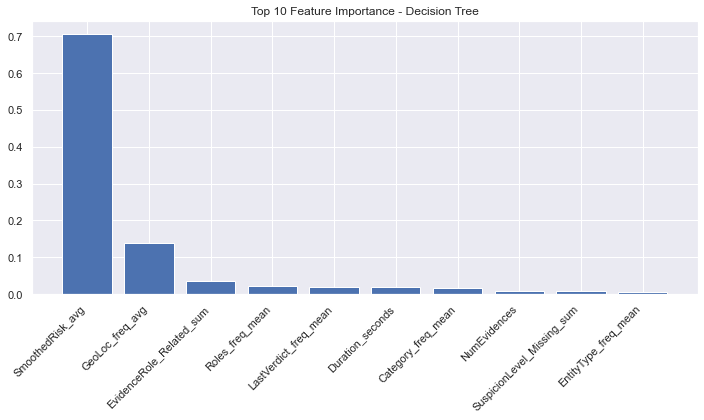

In [19]:
# Training Decision Tree
dt_name, dt_clf = best_classifiers[0]
dt_result = evaluate_classifier(dt_name, dt_clf, X_train, X_test, y_train, y_test)
all_results[dt_name] = dt_result
if dt_result['status'] == 'completed':
    all_predictions[dt_name] = dt_result['predictions']

# Plot feature importance
if dt_result['status'] == 'completed':
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': dt_clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances['importance'][:10])
    plt.xticks(range(10), importances['feature'][:10], rotation=45, ha='right')
    plt.title('Top 10 Feature Importance - Decision Tree')
    plt.tight_layout()
    plt.show()

### 3.2 Random Forest Classifier

Random Forest ha ottenuto la seconda migliore performance con ROC AUC di 0.874


Training Random Forest...

Classification Report:
              precision    recall  f1-score   support

           0     0.8709    0.9812    0.9228    105987
           1     0.8697    0.4626    0.6039     28684

    accuracy                         0.8708    134671
   macro avg     0.8703    0.7219    0.7634    134671
weighted avg     0.8706    0.8708    0.8549    134671


ROC AUC: 0.8736
Training time: 32.48 seconds

Classification Report:
              precision    recall  f1-score   support

           0     0.8709    0.9812    0.9228    105987
           1     0.8697    0.4626    0.6039     28684

    accuracy                         0.8708    134671
   macro avg     0.8703    0.7219    0.7634    134671
weighted avg     0.8706    0.8708    0.8549    134671


ROC AUC: 0.8736
Training time: 32.48 seconds


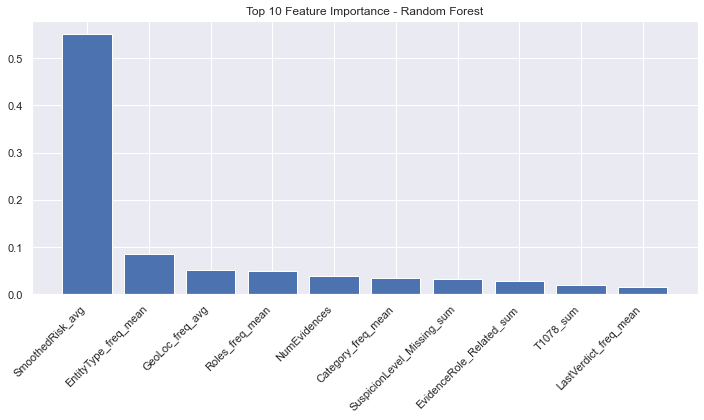

In [20]:
# Training Random Forest
rf_name, rf_clf = best_classifiers[1]
rf_result = evaluate_classifier(rf_name, rf_clf, X_train, X_test, y_train, y_test)
all_results[rf_name] = rf_result
if rf_result['status'] == 'completed':
    all_predictions[rf_name] = rf_result['predictions']

# Plot feature importance
if rf_result['status'] == 'completed':
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances['importance'][:10])
    plt.xticks(range(10), importances['feature'][:10], rotation=45, ha='right')
    plt.title('Top 10 Feature Importance - Random Forest')
    plt.tight_layout()
    plt.show()

### 3.3 AdaBoost Classifier

AdaBoost ha mostrato buone performance con ROC AUC di 0.851 e la precision più alta


Training AdaBoost...

Classification Report:
              precision    recall  f1-score   support

           0     0.8439    0.9942    0.9129    105987
           1     0.9376    0.3203    0.4775     28684

    accuracy                         0.8507    134671
   macro avg     0.8908    0.6573    0.6952    134671
weighted avg     0.8638    0.8507    0.8202    134671


ROC AUC: 0.8513
Training time: 90.24 seconds

Classification Report:
              precision    recall  f1-score   support

           0     0.8439    0.9942    0.9129    105987
           1     0.9376    0.3203    0.4775     28684

    accuracy                         0.8507    134671
   macro avg     0.8908    0.6573    0.6952    134671
weighted avg     0.8638    0.8507    0.8202    134671


ROC AUC: 0.8513
Training time: 90.24 seconds


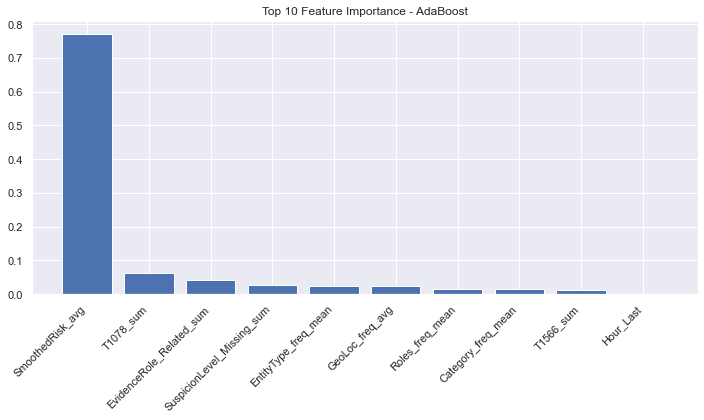

In [21]:
# Training AdaBoost
ada_name, ada_clf = best_classifiers[2]
ada_result = evaluate_classifier(ada_name, ada_clf, X_train, X_test, y_train, y_test)
all_results[ada_name] = ada_result
if ada_result['status'] == 'completed':
    all_predictions[ada_name] = ada_result['predictions']

# Plot feature importance
if ada_result['status'] == 'completed':
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': ada_clf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances['importance'][:10])
    plt.xticks(range(10), importances['feature'][:10], rotation=45, ha='right')
    plt.title('Top 10 Feature Importance - AdaBoost')
    plt.tight_layout()
    plt.show()

### 3.4 QDA Classifier

QDA ha ottenuto un ROC AUC di 0.788 con il recall più alto

In [22]:
# Training QDA
qda_name, qda_clf = best_classifiers[3]
qda_result = evaluate_classifier(qda_name, qda_clf, X_train, X_test, y_train, y_test)
all_results[qda_name] = qda_result
if qda_result['status'] == 'completed':
    all_predictions[qda_name] = qda_result['predictions']


Training QDA...

Classification Report:
              precision    recall  f1-score   support

           0     0.8740    0.0313    0.0604    105987
           1     0.2155    0.9833    0.3535     28684

    accuracy                         0.2341    134671
   macro avg     0.5448    0.5073    0.2070    134671
weighted avg     0.7338    0.2341    0.1228    134671


ROC AUC: 0.7883
Training time: 2.32 seconds

Classification Report:
              precision    recall  f1-score   support

           0     0.8740    0.0313    0.0604    105987
           1     0.2155    0.9833    0.3535     28684

    accuracy                         0.2341    134671
   macro avg     0.5448    0.5073    0.2070    134671
weighted avg     0.7338    0.2341    0.1228    134671


ROC AUC: 0.7883
Training time: 2.32 seconds


### 3.5 K-Nearest Neighbors Classifier

KNN ha ottenuto un ROC AUC di 0.733

In [23]:
# Training KNN
knn_name, knn_clf = best_classifiers[4]
knn_result = evaluate_classifier(knn_name, knn_clf, X_train, X_test, y_train, y_test)
all_results[knn_name] = knn_result
if knn_result['status'] == 'completed':
    all_predictions[knn_name] = knn_result['predictions']


Training K-Nearest Neighbors...

Classification Report:
              precision    recall  f1-score   support

           0     0.8542    0.9204    0.8861    105987
           1     0.5880    0.4195    0.4897     28684

    accuracy                         0.8137    134671
   macro avg     0.7211    0.6700    0.6879    134671
weighted avg     0.7975    0.8137    0.8017    134671


ROC AUC: 0.7327
Training time: 108.15 seconds

Classification Report:
              precision    recall  f1-score   support

           0     0.8542    0.9204    0.8861    105987
           1     0.5880    0.4195    0.4897     28684

    accuracy                         0.8137    134671
   macro avg     0.7211    0.6700    0.6879    134671
weighted avg     0.7975    0.8137    0.8017    134671


ROC AUC: 0.7327
Training time: 108.15 seconds


## 4. Confronto Performance e Correlazioni

Confrontiamo le performance dei migliori classificatori e analizziamo le correlazioni tra le loro predizioni.

## 3. Training e Valutazione per Singolo Classificatore

Addestriamo e valutiamo ogni classificatore separatamente per una migliore analisi delle performance individuali.

In [24]:
# Crea DataFrame con risultati
completed_results = [r for r in all_results.values() if r['status'] == 'completed']
metrics_df = pd.DataFrame(completed_results)

if len(completed_results) > 0:
    metrics_df = metrics_df[[
        'name', 'accuracy', 'precision', 'recall', 
        'f1', 'roc_auc', 'training_time'
    ]].sort_values('roc_auc', ascending=False)

    print("\nPerformance Classificatori:")
    print("="*100)
    print(metrics_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))

# Lista modelli con timeout/errori
failed = [r for r in all_results.values() if r['status'] != 'completed']
if failed:
    print("\nModelli non completati:")
    for r in failed:
        print(f"- {r['name']}: {r['status']}")


Performance Classificatori:
               name  accuracy  precision  recall     f1  roc_auc  training_time
      Decision Tree    0.8737     0.8514  0.4931 0.6245   0.8769         6.7838
      Random Forest    0.8708     0.8697  0.4626 0.6039   0.8736        32.4776
           AdaBoost    0.8507     0.9376  0.3203 0.4775   0.8513        90.2352
                QDA    0.2341     0.2155  0.9833 0.3535   0.7883         2.3219
K-Nearest Neighbors    0.8137     0.5880  0.4195 0.4897   0.7327       108.1462


## 5. Correlation Matrix tra Predizioni

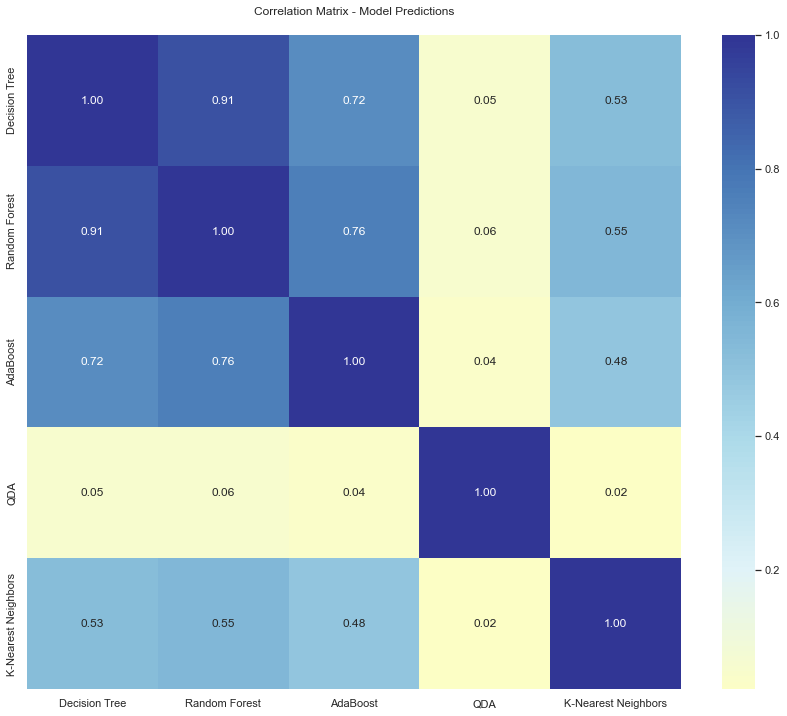


Interpretazione Correlazioni:
- Valori vicini a 1: modelli con predizioni molto simili
- Valori vicini a 0: modelli con predizioni indipendenti
- Valori negativi: modelli con predizioni inverse


In [25]:
if len(all_predictions) > 1:
    # Crea DataFrame con predizioni
    pred_df = pd.DataFrame(all_predictions)
    
    # Calcola matrice di correlazione
    corr_matrix = pred_df.corr()
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap='RdYlBu', 
        center=0,
        fmt='.2f',
        square=True
    )
    plt.title('Correlation Matrix - Model Predictions', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretazione Correlazioni:")
    print("- Valori vicini a 1: modelli con predizioni molto simili")
    print("- Valori vicini a 0: modelli con predizioni indipendenti")
    print("- Valori negativi: modelli con predizioni inverse")

## Summary

**Confronto classificatori completato!**

- I modelli sono ordinati per ROC AUC score
- Training time indica l'efficienza computazionale
- La matrice di correlazione mostra la similarità tra le predizioni
- Modelli con timeout sono stati interrotti dopo 4 minuti

Note:
- Alcuni modelli potrebbero richiedere feature scaling
- Hyperparameter tuning potrebbe migliorare le performance
- Memory usage potrebbe essere ottimizzato per modelli complessi